**Simple Genetic algorithm for neuroevolution** 

This notebook aims to find a solution to flappy bird by using a simple genetic algorithm to conduct a large search to fit a neural network. The algorithm is based on genomes consisting of a bitstring, mapping the bits to a neural network. 

In [82]:
# imports
import numpy as np
import flappy_bird_gymnasium
import gymnasium
import random

Create a structure organism in order to keep track of the chromosome and the fitness

In [83]:
class Organism:
    def __init__(self, chromosome, fitness):
        self.chromosome = ""
        self.fitness = 0

The cell below contains functions for converting the chromosome into a neural network, as well as useful functions like forward pass in order to let the creatures make predictions. 

In [84]:
def bitstring_to_floats(bitstring, bits_per_value=10, min_val=-2, max_val=2):
    """Converts a bitstring into an array of float values while ensuring full extraction."""
    num_values = len(bitstring) // bits_per_value  # Ensure full number of weights
    if num_values == 0:
        raise ValueError("Bitstring too short for any weights!")

    floats = []
    for i in range(num_values):
        binary_segment = bitstring[i * bits_per_value:(i + 1) * bits_per_value]
        decimal_value = int(binary_segment, 2)  # Convert binary to decimal
        scaled_value = min_val + (max_val - min_val) * (decimal_value / (2**bits_per_value - 1))  # Normalize to [-2,2]
        floats.append(scaled_value)

    return np.array(floats)


def decode_architecture(bitstring, bits_per_weight=10):
    """Extracts NN structure (neurons) and weights from a bitstring"""
    hidden_neurons = int(bitstring[:4], 2) + 1  # Allow 1-16 hidden neurons
    weights = bitstring_to_floats(bitstring[4:], bits_per_value=bits_per_weight)  # Convert remaining bits to weights

    # Compute expected weights
    required_params = (1 * hidden_neurons) + (hidden_neurons) + (hidden_neurons * 1) + 1

    if len(weights) < required_params:
        raise ValueError(f"Decoded weights ({len(weights)}) are fewer than expected ({required_params}). "
                         f"Ensure bitstring is at least {required_params * bits_per_weight} bits long!")

    return hidden_neurons, weights


def construct_nn(bitstring):
    """Constructs a simple 1-layer NN from a bitstring with dynamic hidden neurons"""
    hidden_neurons, params = decode_architecture(bitstring)

    expected_params = (1 * hidden_neurons) + (hidden_neurons) + (hidden_neurons * 1) + 1
    if len(params) < expected_params:
        raise ValueError(f"Not enough parameters ({len(params)}) for {hidden_neurons} hidden neurons. "
                         f"Expected at least {expected_params}.")

    # Dynamically assign weights
    w1 = params[:hidden_neurons].reshape(1, hidden_neurons)  # Input → Hidden
    b1 = params[hidden_neurons:hidden_neurons*2].reshape(1, hidden_neurons)
    w2 = params[hidden_neurons*2:hidden_neurons*3].reshape(hidden_neurons, 1)  # Hidden → Output
    b2 = np.array(params[hidden_neurons*3]).reshape(1, 1)  # Output bias

    return w1, b1, w2, b2


def forward_pass(X, w1, b1, w2, b2):
    """Runs a forward pass through the neural network"""
    hidden = np.tanh(X @ w1 + b1)  # Hidden layer (Tanh activation)
    output = np.tanh(hidden @ w2 + b2)  # Output layer (Tanh for [-1,1] range)
    return output


def required_bitstring_length(hidden_neurons, bits_per_weight=10):
    """Computes the required genome size based on hidden neurons and bit encoding size."""
    num_weights = (1 * hidden_neurons) + (hidden_neurons) + (hidden_neurons * 1) + 1
    return num_weights * bits_per_weight + 4  # Ensure enough bits are allocated




In [85]:


env = gymnasium.make("FlappyBird-v0", use_lidar=False)


# ===============================================================
# Neural network parameters:
# ===============================================================
num_inputs = 12 # The envirement has 12 observations for each frame
num_outputs = 1 # The envirement has 1 action space (flap or do nothing)


def evaluate(chromosome):
    """Evaluates a chromosome based on its fitness."""
    hidden_neurons, params = decode_architecture(chromosome)
    w1, b1, w2, b2 = construct_nn(chromosome)

    # Run the game
    obs, _ = env.reset()
    total_reward = 0
    while True:
        # Process the observation
        X = obs.reshape(1, -1)  # Convert to row vector

        # Forward pass through the NN
        output = forward_pass(X, w1, b1, w2, b2)

        # Compute the action
        action = 1 if output > 0 else 0

        # Take the action
        obs, reward, terminated, _, _ = env.step(action)
        total_reward += reward

        # Check if the game is over
        if terminated:
            break

    return total_reward



In [86]:
def evaluate_fitness(bitstring, X, y):
    """Evaluates the NN's fitness as the inverse error"""
    w1, b1, w2, b2 = construct_nn(bitstring)
    
    predictions = forward_pass(X, w1, b1, w2, b2).flatten()  # Ensure proper shape
    
    mse = np.mean((predictions - y) ** 2)
    return 1 / (mse + 1e-6)  # Higher fitness for lower error

In [87]:
def uniform_crossover(parent1, parent2):
    """Uniform crossover for binary genomes"""
    mask = np.random.randint(2, size=len(parent1))  # Random bit mask
    child1 = "".join([parent1[i] if mask[i] else parent2[i] for i in range(len(parent1))])
    child2 = "".join([parent2[i] if mask[i] else parent1[i] for i in range(len(parent1))])
    return child1, child2


In [88]:
def bit_flip_mutation(bitstring, mutation_rate=0.02):
    """Flips random bits with given probability"""
    return "".join([bit if np.random.rand() > mutation_rate else str(1 - int(bit)) for bit in bitstring])


def adaptive_mutate(chromosome, generation, max_generations, mutation_rate=0.05, diversity_factor=1):
    """Adapts mutation rate based on population diversity."""
    adjusted_mutation_rate = mutation_rate * (1 - (generation / max_generations)) * diversity_factor

    chromosome_list = list(chromosome)  # Convert to mutable list
    for i in range(len(chromosome_list)):
        if np.random.rand() < adjusted_mutation_rate:
            chromosome_list[i] = '1' if chromosome_list[i] == '0' else '0'  # Flip bit

    return "".join(chromosome_list)  # Convert back to string



In [89]:
def deterministic_crowding(parent1, parent2, child1, child2, fitness_function, X, y):
    """Ensures offspring compete with similar parents."""
    f_p1 = fitness_function(parent1, X, y)
    f_p2 = fitness_function(parent2, X, y)
    f_c1 = fitness_function(child1, X, y)
    f_c2 = fitness_function(child2, X, y)

    new1 = child1 if f_c1 > f_p1 else parent1
    new2 = child2 if f_c2 > f_p2 else parent2

    return new1, new2


In [90]:
def hamming_distance(bitstring1, bitstring2):
    """Calculates Hamming distance between two bitstrings."""
    return sum(b1 != b2 for b1, b2 in zip(bitstring1, bitstring2))


def fitness_sharing(population, fitnesses, sigma_share=10, alpha=2):
    """Applies fitness sharing to promote diversity."""
    shared_fitnesses = np.zeros(len(fitnesses))

    for i in range(len(population)):
        niche_count = 0
        for j in range(len(population)):
            if i != j:
                distance = hamming_distance(population[i], population[j])
                if distance < sigma_share:  # If genomes are similar
                    niche_count += (1 - (distance / sigma_share)) ** alpha

        shared_fitnesses[i] = fitnesses[i] / (1 + niche_count)  # Penalize common solutions

    return shared_fitnesses


In [91]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """Select best genome from a random subset"""
    indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = indices[np.argmax([fitnesses[i] for i in indices])]
    return population[best_index]


def roulette_wheel_selection(population, fitnesses):
    """Selects individuals using fitness proportionate selection."""
    total_fitness = np.sum(fitnesses)
    probabilities = fitnesses / total_fitness
    return population[np.random.choice(len(population), p=probabilities)]


In [92]:
def genetic_algorithm(pop_size, genome_length, generations, X, y):
    """Runs a genetic algorithm to evolve a neural network"""
    # Initialize population (random bitstrings)
    population = ["".join(np.random.choice(["0", "1"], genome_length)) for _ in range(pop_size)]
    max_generation = population

    for gen in range(generations):
        fitnesses = np.array([evaluate_fitness(ind, X, y) for ind in population])
        fitnesses = fitness_sharing(population, fitnesses)  # Apply fitness sharing
        
        new_population = []
        while len(new_population) < pop_size:
            # Select parents
            #parent1, parent2 = tournament_selection(population, fitnesses), tournament_selection(population, fitnesses)
            parent1 = roulette_wheel_selection(population, fitnesses)
            parent2 = roulette_wheel_selection(population, fitnesses)
            # Crossover & Mutation
            child1, child2 = uniform_crossover(parent1, parent2)
            #child1, child2 = bit_flip_mutation(child1), bit_flip_mutation(child2)
            diversity_factor = 1 + (np.mean(fitness_sharing(population, fitnesses)) * 0.5)  # Scale mutation if diversity is low
            child1 = adaptive_mutate(child1, gen, generations, diversity_factor=diversity_factor)
            child2 = adaptive_mutate(child2, gen, generations, diversity_factor=diversity_factor)
            child1, child2 = deterministic_crowding(parent1, parent2, child1, child2, evaluate_fitness, X, y)
            
            new_population.extend([child1, child2])

        # Replace population (keep best elite)
        best_idx = np.argmax(fitnesses)
        best_genome = population[best_idx]
        population = new_population[:pop_size]
        population[0] = best_genome  # Elitism
        if population[np.argmax(fitnesses)] == best_genome:
            max_generation = population
        
        print(f"Generation {gen + 1}: Best Fitness = {max(fitnesses):.6f}")
    
    best_genome = max_generation[np.argmax(fitnesses)]
    print(f"Best genome: {best_genome}")
    return best_genome  # Return best genome


In [93]:
import matplotlib.pyplot as plt

# Generate sine function dataset
X = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
y = np.sin(X).flatten()


Neural Network successfully built with shapes:
w1: (1, 8), b1: (1, 8), w2: (8, 1), b2: (1, 1)
494
Generation 1: Best Fitness = 2.281983
Generation 2: Best Fitness = 2.591126
Generation 3: Best Fitness = 1.140992
Generation 4: Best Fitness = 1.295563
Generation 5: Best Fitness = 2.281983
Generation 6: Best Fitness = 0.863709
Generation 7: Best Fitness = 2.449563
Generation 8: Best Fitness = 1.140992
Generation 9: Best Fitness = 2.632458
Generation 10: Best Fitness = 3.870429
Generation 11: Best Fitness = 2.591126
Generation 12: Best Fitness = 6.770373
Generation 13: Best Fitness = 4.603410
Generation 14: Best Fitness = 6.242123
Generation 15: Best Fitness = 6.242123
Generation 16: Best Fitness = 6.770373
Generation 17: Best Fitness = 4.402211
Generation 18: Best Fitness = 3.870429
Generation 19: Best Fitness = 7.009776
Generation 20: Best Fitness = 1.935215
Generation 21: Best Fitness = 3.385187
Generation 22: Best Fitness = 3.870429
Generation 23: Best Fitness = 2.256791
Generation 24:

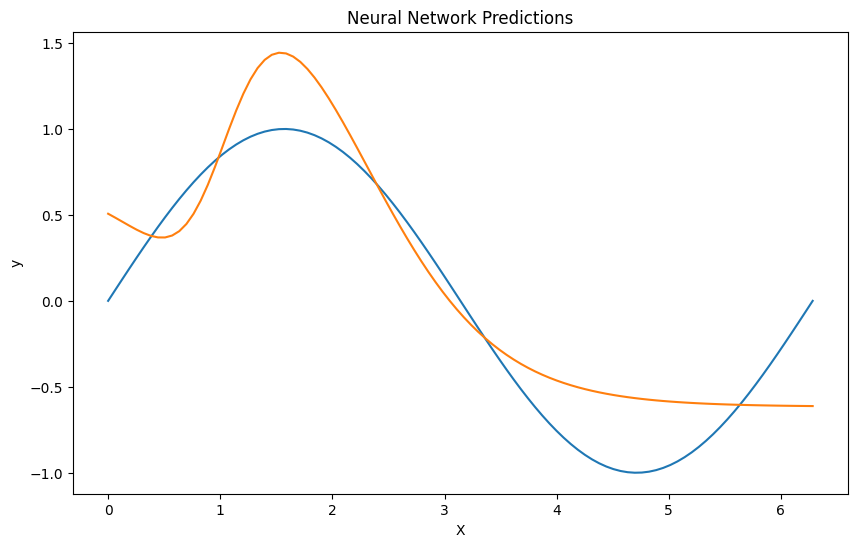

In [ ]:
random_bitstring = "".join(np.random.choice(["0", "1"], required_bitstring_length(hidden_neurons=11)))

try:
    w1, b1, w2, b2 = construct_nn(random_bitstring)
    print("Neural Network successfully built with shapes:")
    print(f"w1: {w1.shape}, b1: {b1.shape}, w2: {w2.shape}, b2: {b2.shape}")
except ValueError as e:
    print("Error:", e)


required_length = required_bitstring_length(hidden_neurons=16)  # Maximum expected neurons
print(required_length)
# TODO: add functionality to choose input size of the neural network
input_size = 12
required_length = required_bitstring_length(hidden_neurons=16) + input_size


best_genome = genetic_algorithm(
    pop_size=10,
    genome_length=required_length,  # 16 parameters × 8 bits
    generations=50,
    X=X, y=y
)


# plot the best NN predictions and the true sine function
w1, b1, w2, b2 = construct_nn(best_genome)
hidden = np.tanh(X @ w1 + b1)
output = hidden @ w2 + b2

# visualize the neural network
plt.figure(figsize=(10, 6))

plt.title("Neural Network Predictions")
plt.xlabel("X")
plt.ylabel("y")


plt.plot(X, y, label="True Sine Function")
plt.plot(X, output, label="NN Predictions")



In [95]:

import flappy_bird_gymnasium
import gymnasium
import random
env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=False)


# ===============================================================
# Neural network parameters:
# ===============================================================
num_inputs = 12 # The envirement has 12 observations for each frame
num_outputs = 1 # The envirement has 1 action space (flap or do nothing)
    
obs, _ = env.reset()
while True:
    
    
    
    # ===============================================================
    # Next action:
    # ===============================================================
    # (feed the observation to your agent here)
    # Action space:
    # 0 - do nothing
    # 1 - flap
    #action = env.action_space.sample()
    action = random.randint(0,1)

    # Processing:
    obs, reward, terminated, _, info = env.step(action)
    print(obs)
    # Rewards:
    # +0.1 - every frame it stays alive
    # +1.0 - successfully passing a pipe
    # -1.0 - dying
    # −0.5 - touch the top of the screen

    
    # Checking if the player is still alive
    if terminated:
        break
    
  

env.close()

[ 0.98611111  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.45898438 -0.9         0.5       ]
[ 0.97222222  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.44335938 -0.8         0.46666667]
[ 0.95833333  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.4296875  -0.7         0.43333333]
[ 0.94444444  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.41210938 -0.9         0.5       ]
[ 0.93055556  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.39648438 -0.8         0.46666667]
[ 0.91666667  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.37890625 -0.9         0.5       ]
[ 0.90277778  0.29296875  0.48828125  1.          0.          1.
  1.          0.          1.          0.36132812 -0.9         0.5       ]
[ 0.88888889  0.29296875  0